# List images and their labels

In [30]:
# List images and their labels
from random import shuffle
import glob
import cv2
import sys
import numpy as np
import tensorflow as tf
#import matplotlib as plt
import matplotlib.pyplot as plt

shuffle_data = True  # shuffle the addresses before saving
training_data_path ='dataset1/*/*/*.jpg'

In [37]:
# read addresses and labels from the 'train' folder
addrs = glob.glob(training_data_path)
labels = []

for addr in addrs:
    if 'dagim_kosher' in addr:
        labels.append(0)
    elif 'taanug_kosher' in addr:
        labels.append(1)
    else:
        labels.append(2)

# labels = [0 if 'dagim_kosher' in addr else 1 for addr in addrs]  # dagim_kosher: 0; taanug_kosher: 1

# print("labels", type(labels))
# print("addrs", type(addrs))

# to shuffle data
if shuffle_data:
    c = list(zip(addrs, labels))
    shuffle(c)
    addrs, labels = zip(*c)
    
# divide the data into 60% train, 20% validation, and 20% test
train_addrs = addrs[0:int(0.6*len(addrs))]
train_labels = labels[0:int(0.6*len(labels))]
val_addrs = addrs[int(0.6*len(addrs)):int(0.8*len(addrs))]
val_labels = labels[int(0.6*len(addrs)):int(0.8*len(addrs))]
test_addrs = addrs[int(0.8*len(addrs)):]
test_labels = labels[int(0.8*len(labels)):]

In [38]:
print("  training data:" + str(len(train_addrs)))
print("validation data:" + str(len(val_addrs)))
print("      test data:" + str(len(test_addrs)))

  training data:121
validation data:41
      test data:41


# Create a TFRecords file

In [39]:
# A function to Load images
def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Write data into a TFRecord file

### write train file

In [40]:
train_filename = 'train.tfrecords'

writer = tf.python_io.TFRecordWriter(train_filename)

for i in range(len(train_addrs)):
    # print how many images are saved every 1000 images
    if not i % 1000:
        print('Train data: {}/{}'.format(i, len(train_addrs)))
        sys.stdout.flush()

    # load the image
    img = load_image(train_addrs[i])

    label = train_labels[i]

    # create a feature
    feature = {'train/label': _int64_feature(label),
               'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

Train data: 0/121


### write validation file

In [41]:
val_filename = 'val.tfrecords'  # address to save the TFRecords file
writer = tf.python_io.TFRecordWriter(val_filename)
for i in range(len(val_addrs)):
    # print how many images are saved every 1000 images
    if not i % 1000:
        print( 'Val data: {}/{}'.format(i, len(val_addrs)))
        sys.stdout.flush()
        
    # Load the image
    img = load_image(val_addrs[i])
    label = val_labels[i]
    
    # Create a feature
    feature = {'val/label': _int64_feature(label),
               'val/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
writer.close()
sys.stdout.flush()

Val data: 0/41


### write test file

In [42]:
test_filename = 'test.tfrecords'  # address to save the TFRecords file
writer = tf.python_io.TFRecordWriter(test_filename)
for i in range(len(test_addrs)):
    # print how many images are saved every 1000 images
    if not i % 1000:
        print( 'Test data: {}/{}'.format(i, len(test_addrs)))
        sys.stdout.flush()
    # Load the image
    img = load_image(test_addrs[i])
    label = test_labels[i]
    # Create a feature
    feature = {'test/label': _int64_feature(label),
               'test/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
writer.close()
sys.stdout.flush()

Test data: 0/41


# Read tfrecords file

img size (20, 224, 224, 3)
label shape (20,)
label shape [1 1 0 0 0 2 0 0 1 1 1 2 0 0 1 2 0 0 0 1]


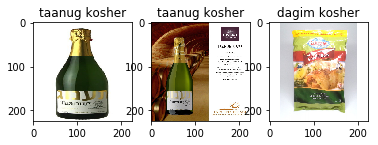

img size (20, 224, 224, 3)
label shape (20,)
label shape [2 2 0 0 2 2 1 2 0 0 2 0 0 2 1 2 2 0 0 0]


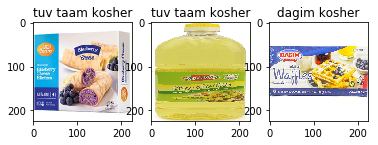

img size (20, 224, 224, 3)
label shape (20,)
label shape [0 2 1 1 0 1 1 1 1 1 2 0 2 0 0 0 2 1 1 0]


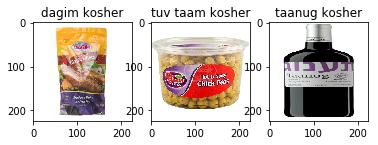

img size (20, 224, 224, 3)
label shape (20,)
label shape [1 1 2 2 0 0 0 1 1 2 1 2 1 1 0 2 2 0 1 0]


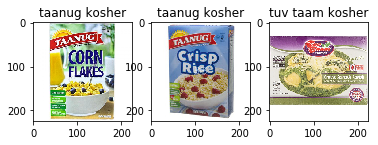

img size (20, 224, 224, 3)
label shape (20,)
label shape [2 0 2 1 0 2 0 0 0 0 1 2 2 0 1 0 2 1 1 1]


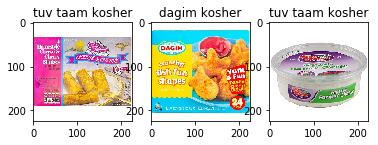

In [65]:
import matplotlib.pyplot as plt
data_path = 'train.tfrecords'  # address to save the hdf5 file
with tf.Session() as sess:
    feature = {'train/image': tf.FixedLenFeature([], tf.string),
               'train/label': tf.FixedLenFeature([], tf.int64)}
    
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['train/image'], tf.float32)
    
    # Cast label data into int32
    label = tf.cast(features['train/label'], tf.int32)
    
    # Reshape image data into the original shape
    image = tf.reshape(image, [224, 224, 3])
    
    # Any preprocessing here ...
    
    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=20, capacity=30, num_threads=1, min_after_dequeue=10)
    
    # Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for batch_index in range(5):
        img, lbl = sess.run([images, labels])
#         print("type of img:", type(img))
        
        # print(str(img.shape), str(lbl.shape), str(type(img)), str(type(lbl)))
        
        # Input image to plot/show with matplotlib's imshow is if
        # MxN -- values to be mapped (float or int)
        # MxNx3 -- RGB (float or uint8)
        # MxNx4 -- RGBA (float or uint8)
        img = img.astype(np.uint8)
        
#         print("type of img:", type(img))
        print("img size", img.shape)
        print("label shape", lbl.shape)
        print("label shape", lbl)

        for j in range(3):
            plt.subplot(2, 3, j+1)
            plt.imshow(img[j, ...])
            if lbl[j]==0:
                plt.title('dagim kosher')
            elif lbl[j]==1:
                plt.title('taanug kosher')
            else:
                plt.title('tuv taam kosher')
                    
#             plt.title('dagim_kosher' if lbl[j]==0 else 'taanug_kosher')
        plt.show()
        
    # Stop the threads
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    sess.close()

### write test file

In [68]:
# open the TFRecords file
test_filename = 'test.tfrecords'  # address to save the TFRecords file
writer = tf.python_io.TFRecordWriter(test_filename)
for i in range(len(test_addrs)):
    # print how many images are saved every 1000 images
    if not i % 1000:
        print( 'Test data: {}/{}'.format(i, len(test_addrs)))
        sys.stdout.flush()
        
    # Load the image
    img = load_image(test_addrs[i])
    label = test_labels[i]
    
    # Create a feature
    feature = {'test/label': _int64_feature(label),
               'test/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

Test data: 0/27


# Read tfrecords file - Customized

In [60]:
train_data_path = 'train.tfrecords'
with tf.Session() as sess:
    feature = {'train/image': tf.FixedLenFeature([], tf.string),
               'train/label': tf.FixedLenFeature([], tf.int64)}
    
    filename_queue = tf.train.string_input_producer([train_data_path], num_epochs=1)
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    
    freatures = tf.parse_single_example(serialized_example, features=feature)
    
    image = tf.decode_raw(features['train/image'], tf.float32)
    
    label = tf.cast(features['train/label'], tf.int32)
    
    image = tf.reshape(image, [224, 224, 3])
    
    images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)
    

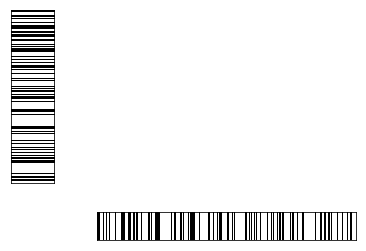

In [64]:
# Fixing random state for reproducibility
np.random.seed(19680801)


# the bar
x = np.where(np.random.rand(500) > 0.7, 1.0, 0.0)

axprops = dict(xticks=[], yticks=[])
barprops = dict(aspect='auto', cmap=plt.cm.binary, interpolation='nearest')

fig = plt.figure()

# a vertical barcode
ax1 = fig.add_axes([0.1, 0.3, 0.1, 0.6], **axprops)
ax1.imshow(x.reshape((-1, 1)), **barprops)

# a horizontal barcode
ax2 = fig.add_axes([0.3, 0.1, 0.6, 0.1], **axprops)
ax2.imshow(x.reshape((1, -1)), **barprops)


plt.show()